In [1]:
# compare the data/mc for cluster shape/position, variables used for BDT training
# to make sure the bdt is not just learning about the difference between data/mc

import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections
from collections import OrderedDict
import uproot
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, make_ratio_plot
import os
import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

wH = 1
Z_MASS = 91.2

# donotdelete = []
print(sys.version)

Welcome to JupyROOT 6.22/02
3.6.8 (default, Apr  2 2020, 13:34:55) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


In [2]:
fpath_bkg =OrderedDict()
tree_bkg = OrderedDict()
tree_sig = OrderedDict()
fpath_sig =OrderedDict()
year = '2017'
category = 0
ver = 'V1p17'
sig_ver = 'v27'
singleMuon = True
if singleMuon:
    if sig_ver == 'v14':data_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ver+'/Data'+year+'/v5/v12/normalized/'
    else: data_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ver+'/Data'+year+'/v5/'+sig_ver+'/normalized/'
    if year == 'full': data_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/Data2018/v5/v9/normalized/'
else:
    data_path = '/mnt/hadoop//store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/Data2018/v1/v29/normalized/'
bkg_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_Fall17/v1/'+sig_ver+'/normalized/'
sig_path = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_Fall18/v1/v4/normalized/'



lumi = (5.632467289 +2.572903489 +1.685313225 +3.988453305 +3.068943620 +3.527270568 +8.609721915) * 1000
lumi = 41.53*1000
print("lumi is "+str(round(lumi/1000,2))+" fb-1")
fpath_bkg['mc_signal'] = sig_path+"ZH_HToSSTobbbb_ms55_1pb_weighted.root"
# fpath_bkg['dy_50_120'] = bkg_path + 'ZToMuMu_NNPDF31_13TeV-powheg_M_50_120_1pb_weighted.root'
# fpath_bkg['dy_120_200'] = bkg_path + 'ZToMuMu_NNPDF31_13TeV-powheg_M_120_200_1pb_weighted.root'
# fpath_bkg['dy_200_400'] = bkg_path + 'ZToMuMu_NNPDF31_13TeV-powheg_M_200_400_1pb_weighted.root'
# fpath_bkg['dy_400_800'] = bkg_path + 'ZToMuMu_NNPDF31_13TeV-powheg_M_400_800_1pb_weighted.root'
# fpath_bkg['dy_50_800'] = bkg_path + 'ZToMuMu_NNPDF31_13TeV-powheg_M_50_800_1pb_weighted.root'
# fpath_bkg['dy_50_Inf'] = bkg_path + 'ZToMuMu_NNPDF31_13TeV-powheg_M_50_Inf_1pb_weighted.root'
# fpath_bkg['dy_50_800'] = bkg_path + 'ZToMuMu_NNPDF31_13TeV-powheg_M_50_800_1pb_weighted.root'
fpath_bkg['dy_120_800'] = bkg_path + 'ZToMuMu_NNPDF31_13TeV-powheg_M_120_800_1pb_weighted.root'



        


if year=='2018':fpath_bkg['data'] = data_path+"Run2_displacedJetMuonNtupler_V1p17_Data2018_17Sept2018_Run2018-ZMu-17Sep2018_goodLumi.root"
elif year=='2017': fpath_bkg['data'] = data_path+"Run2_displacedJetMuonNtupler_V1p17_Data2017_Run2017-ZMu-17Nov2017_goodLumi.root"
elif year=='2016': fpath_bkg['data'] = data_path+"Run2_displacedJetMuonNtupler_V1p17_Data2016_Run2016-ZMu-07Aug17_goodLumi.root"
elif year == 'all':
    fpath_bkg['data16'] = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ver+'/Data2016/v5/'+sig_ver+'/normalized/'\
        +"Run2_displacedJetMuonNtupler_V1p17_Data2016_Run2016-ZMu-07Aug17_goodLumi.root"
    fpath_bkg['data17'] = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ver+'/Data2017/v5/'+sig_ver+'/normalized/'\
    +"Run2_displacedJetMuonNtupler_V1p17_Data2017_Run2017-ZMu-17Nov2017_goodLumi.root"
    fpath_bkg['data18'] = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ver+'/Data2018/v5/'+sig_ver+'/normalized/'\
    +"Run2_displacedJetMuonNtupler_V1p17_Data2018_17Sept2018_Run2018-ZMu-17Sep2018_goodLumi.root"


else: fpath_bkg['data'] = data_path+"Run2_displacedJetMuonNtupler_V1p17_Data2016_Data2017_Data2018-ZMu_goodLumi.root"



lumi is 41.53 fb-1


In [3]:
for k,v in fpath_bkg.items():
    print (k, v)
    root_dir = uproot.open(v) 
    tree_bkg[k] = root_dir['MuonSystem']
    a = tree_bkg[k]["weight"].array()
    print (np.unique(a)*lumi)
    print(a.shape)

mc_signal /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_Fall18/v1/v4/normalized/ZH_HToSSTobbbb_ms55_1pb_weighted.root
[-0.01223313 -0.01202157  0.01202157  0.01223313]
(110259,)
dy_120_800 /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_Fall17/v1/v27/normalized/ZToMuMu_NNPDF31_13TeV-powheg_M_120_800_1pb_weighted.root
[-8.627941  -1.2055961 -0.1042499  0.1042499  1.2055961  8.627941 ]
(144157,)
data /mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/Data2017/v5/v27/normalized/Run2_displacedJetMuonNtupler_V1p17_Data2017_Run2017-ZMu-17Nov2017_goodLumi.root
[41530.]
(940825,)


# load BDT

In [5]:
import pandas as pd
import pickle

bdt_name = 'bdt_flatten_metfilter_me1112nohits_eta2p0_testsize0p2_noSpread_v3'
bdt_cut = 0.29001525
# model = pickle.load(open(bdt_name+'.pickle', "rb" ))


In [6]:
rechit_cut = {}
rechit_cut['v11'] = 50

rechit_cut['v14'] = 50
rechit_cut['v15'] = 40
rechit_cut['v16'] = 60
rechit_cut['v17'] = 70
rechit_cut['v18'] = 30
rechit_cut['v24'] = 130
rechit_cut['v28'] = 250



rechit_cut['v19'] = 50 #0.15
rechit_cut['v20'] = 50 #0.1
rechit_cut['v21'] = 50 #0.25
rechit_cut['v22'] = 50 #0.3
rechit_cut['v23'] = 50 #0.4

rechit_cut['v25'] = 130 #0.1
rechit_cut['v24'] = 130 #0.2
rechit_cut['v26'] = 130 #0.3
rechit_cut['v27'] = 130 #0.4


### Cluster efficiency

In [7]:
%%time

jetPt_cut = 50
tightid = False
pileupWeight = {}
weight = {}
ZPt = {}
ZMass = {}
lepPt = {}
lepEta = {}
lepE = {}
lepE_tag = {}
lepEta_tag = {}
lepPt_tag = {}
cscRechitClusterEta = {}
cscRechitClusterSize = {}
cscRechitClusterNStation10 = {}
cscRechitClusterAvgStation10 = {}
mc_corr_weight = {}
rho = {}
npu = {}
npv = {}
tag_index = {}
probe_index = {}
lepOverallSF = {}
sel_lep = {}
sel_ev = {}
lepSF = {}
cond = {}
cscRechitClusterEta = {}
sel_tp = {}
bdt_score = {}
cut_based = {}
id_eff = {}
nrechits_eff = {}
id_wrt_nrechit = {}
id_pEff = {}
id_wrt_nrechit_pEff = {}
nrechit_pEff = {}
muonPt = 50
norm = 50
tag_probe = True
masses = [('120','800')]
for (m1,m2) in masses:
    keys = ['data', 'dy_'+m1+'_'+m2]
    for k in ['data', 'dy_'+m1+'_'+m2]:
        T = tree_bkg[k]
    ########## select cluster ########
        sel_cluster = np.abs(T.array('cscRechitCluster3Time')) < 12.5

        sel_cluster = np.logical_and(sel_cluster, np.abs(T.array('cscRechitCluster3Size'))>=rechit_cut[sig_ver])
        sel_cluster = np.logical_and(sel_cluster, np.abs(T.array('cscRechitCluster3TimeSpread'))<20)
        sel_cluster = np.logical_and(sel_cluster, np.abs(T.array('cscRechitCluster3MaxChamber')) > 12)
        sel_cluster = np.logical_and(sel_cluster, np.abs(T.array('cscRechitCluster3Eta')) < 2.0)    
        sel_cluster = np.logical_and(sel_cluster, np.abs(T.array('cscRechitCluster3MuonVetoPt')) > muonPt)
        sel_cluster = np.logical_and(sel_cluster, np.logical_or(T.array('cscRechitCluster3ZLep1') == 1, T.array('cscRechitCluster3ZLep2') == 1))
        if k[:2] == 'dy':sel_cluster = np.logical_and(sel_cluster, T.array('cscRechitCluster3GenMuonVetoPt') > muonPt)
        if tag_probe: 
            sel_cluster1 =np.logical_and(sel_cluster,  T.array('cscRechitCluster3ZLep1') == 1)   #loose lepton
            sel_cluster2 = np.logical_and(sel_cluster,  T.array('cscRechitCluster3ZLep2') == 1)  
        
    # ########### BRANCHES ############
        sel_lep[k] = np.logical_and(T.array('lepPassId')==1, T.array("lepPassTightIso")==1) #tight iso+id lepton
        sel_lep[k] = np.logical_and(sel_lep[k], np.abs(T.array("lepPdgId"))==13) #tight iso+id lepton
        sel_ev[k] = sel_lep[k].sum()>=1
        sel_ev[k] = np.logical_and(sel_ev[k], (T.array('lepPt')>= muonPt).sum()==2)
        if k[:2] == 'dy':sel_ev[k] = np.logical_and(sel_ev[k], T.array('lepFromZ').sum()==2)
        sel_ev[k] = np.logical_and(sel_ev[k], T.array("Flag2_all"))
        sel_ev[k] = np.logical_and(sel_ev[k], T.array('category')==2)
        sel_ev[k] = np.logical_and(sel_ev[k], T['HLTDecision'].array()[:,136])
        if m1 == '50':
            sel_ev[k] = np.logical_and(sel_ev[k], T.array('ZMass')>=int(60))
        else:
            sel_ev[k] = np.logical_and(sel_ev[k], T.array('ZMass')>=int(m1))
        sel_ev[k] = np.logical_and(sel_ev[k], T.array('ZMass')<int(m2))
#         sel_ev[k] = np.logical_and(sel_ev[k], T.array('nCscRechitClusters3')>0)

        probe_index[k] = []
        sel_tp[k] = []
        cond[k] = []
        sel_probecluster = []
        pdgid = T.array("lepPdgId")


        index = 0
        for i, ev in enumerate(sel_ev[k]):
            if ev:
                if sel_lep[k][i][0]:
                    probe_index[k].append([False,True])
                    sel_tp[k].append(index)
                    if pdgid[i][0] == 13:
                        cond[k].append(np.logical_and(sel_cluster2[i].sum()==1, sel_cluster1[i].sum()==0))
                        if cond[k][-1]: sel_probecluster.append(list(sel_cluster2[i]))
                    else:
                        cond[k].append(np.logical_and(sel_cluster1[i].sum()==1, sel_cluster2[i].sum()==0)) 
                        if cond[k][-1]:sel_probecluster.append(list(sel_cluster1[i]))
                if sel_lep[k][i][1]:
                    probe_index[k].append([True, False])
                    sel_tp[k].append(index)
                    if pdgid[i][0] == -13:
                        cond[k].append(np.logical_and(sel_cluster2[i].sum()==1, sel_cluster1[i].sum()==0))
                        if cond[k][-1]:sel_probecluster.append(list(sel_cluster2[i]))
                    else:
                        cond[k].append(np.logical_and(sel_cluster1[i].sum()==1, sel_cluster2[i].sum()==0)) 
                        if cond[k][-1]:sel_probecluster.append(list(sel_cluster1[i]))
                index+=1
        sel_tp[k] = np.array(sel_tp[k])
        probe_index[k] = np.array(probe_index[k])
        cond[k] = np.array(cond[k])
        sel_probecluster = awkward.fromiter(sel_probecluster)

        weight[k] = T.array('weight')[sel_ev[k]][sel_tp[k]]*lumi
        pileupWeight[k] = T.array('pileupWeight')[sel_ev[k]][sel_tp[k]]
        if k[:2] == 'dy': lepOverallSF[k] = T.array('lepOverallSF')[sel_ev[k]][sel_tp[k]]
#         if k[:2] == 'dy': lepOverallSF[k] = pileupWeight[k]*0.0+1.0


            
        ZMass[k]= T.array('ZMass')[sel_ev[k]][sel_tp[k]]
        ZPt[k] = T.array('ZPt')[sel_ev[k]][sel_tp[k]]
        mc_corr_weight[k] =  T.array('ZMass')[sel_ev[k]][sel_tp[k]]
        # with pT > 50
        if norm == 50:
            mc_corr_weight[k][np.logical_and(ZMass[k]>=50,ZMass[k]<120)] = 1.0734578
            mc_corr_weight[k][np.logical_and(ZMass[k]>=120,ZMass[k]<200)] = 1.1120967
            mc_corr_weight[k][np.logical_and(ZMass[k]>=200,ZMass[k]<400)] = 1.393718
            mc_corr_weight[k][np.logical_and(ZMass[k]>=400,ZMass[k]<800)] = 1.4190247
#             mc_corr_weight[k][np.logical_and(ZMass[k]>=50,ZMass[k]<120)] = 0.91870093
#             mc_corr_weight[k][np.logical_and(ZMass[k]>=120,ZMass[k]<200)] = 1.1795386
#             mc_corr_weight[k][np.logical_and(ZMass[k]>=200,ZMass[k]<400)] = 1.5143042
#             mc_corr_weight[k][np.logical_and(ZMass[k]>=400,ZMass[k]<800)] = 1.4587245
            
        lepE[k] = np.array(T.array('lepE')[sel_ev[k]][sel_tp[k]])[probe_index[k]]
        lepEta[k] = np.array(T.array('lepEta')[sel_ev[k]][sel_tp[k]])[probe_index[k]]
        lepPt[k] = np.array(T.array('lepPt')[sel_ev[k]][sel_tp[k]])[probe_index[k]]

        if k[:2] == 'dy':lepSF[k] = np.array(T.array('lepSF')[sel_ev[k]][sel_tp[k]])[probe_index[k]]
#         if k[:2] == 'dy':lepSF[k] = lepPt[k]*0.0+1.0


        if k[:4] == 'data':
            pileupWeight[k] = pileupWeight[k] * 0.0 + 1.0
            weight[k] = weight[k] * 0.0 + 1.0
            mc_corr_weight[k] = weight[k] * 0.0 + 1.0
            
        cscRechitClusterEta[k] = awkward.fromiter(T.array('cscRechitCluster3Eta')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]
        cscRechitClusterSize[k] = awkward.fromiter(T.array('cscRechitCluster3Size')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]
        cscRechitClusterNStation10[k] = awkward.fromiter(T.array('cscRechitCluster3NStation10')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]
        cscRechitClusterAvgStation10[k] = awkward.fromiter(T.array('cscRechitCluster3AvgStation10')[sel_ev[k]][sel_tp[k]][cond[k]])[sel_probecluster][:,0]


        if bdt_name =='bdt_flatten_metfilter_me1112nohits_eta2p0_testsize0p2_noSpread_v3':
            bdt_var = {'cscRechitClusterNStation10': cscRechitClusterNStation10[k],
            'cscRechitClusterEta':np.abs(cscRechitClusterEta[k]),
            'cscRechitClusterAvgStation10':np.abs(cscRechitClusterAvgStation10[k]),
        }
        dataset = pd.DataFrame(bdt_var)
        bdt_score[k] = model.predict_proba(dataset.values)[:, 1] 
        
        cond2 = np.logical_and(np.abs(cscRechitClusterAvgStation10[k])==2, np.abs(cscRechitClusterEta[k]) < 1.6)
        cond3 = np.logical_and(np.abs(cscRechitClusterAvgStation10[k])==3, np.abs(cscRechitClusterEta[k]) < 1.6)
        cond4 = np.logical_and(np.abs(cscRechitClusterAvgStation10[k])==4, np.abs(cscRechitClusterEta[k]) < 1.8)
        cond1 = np.logical_and(cscRechitClusterNStation10[k]==1, np.logical_or(np.logical_or(np.abs(cscRechitClusterAvgStation10[k])==1, cond2), np.logical_or(cond3, cond4)))
        cond2 = np.logical_and(cscRechitClusterNStation10[k] > 1, np.abs(cscRechitClusterEta[k]) < 1.9)
        cut_based[k] = np.logical_or(np.logical_or(cond1, cond2), np.logical_or(cond3, cond4))
        
        total_weight = weight[k]*pileupWeight[k]*mc_corr_weight[k]
        if k[:2] == 'dy': total_weight *= lepOverallSF[k]
        total_weight = total_weight[cond[k]]
        id_eff[k] = np.sum(total_weight[cut_based[k]])/np.sum(total_weight)
        nrechits_cut = cscRechitClusterSize[k]>=130
        nrechits_eff[k] =  np.sum(total_weight[nrechits_cut])/np.sum(total_weight)
        id_wrt_nrechit[k] = np.sum(total_weight[np.logical_and(nrechits_cut, cut_based[k])])/np.sum(total_weight[nrechits_cut])
        
        hm = create_TH1D(total_weight[cut_based[k]]*0.0+0.5, 'hm1', axis_title = ['','Cluster Efficiency'], binning=[1,0,1], weights = total_weight[cut_based[k]])
        hb = create_TH1D(total_weight*0.0+0.5, 'hb1', axis_title = ['','Cluster Efficiency'], binning=[1,0,1], weights = total_weight)
        id_pEff[k] = rt.TEfficiency(hm,hb)
    
        hm = create_TH1D(total_weight[nrechits_cut]*0.0+0.5, 'hm1', axis_title = ['','Cluster Efficiency'], binning=[1,0,1], weights = total_weight[nrechits_cut])
        hb = create_TH1D(total_weight*0.0+0.5, 'hb1', axis_title = ['','Cluster Efficiency'], binning=[1,0,1], weights = total_weight)
        nrechit_pEff[k] = rt.TEfficiency(hm,hb)
    
        hm = create_TH1D(total_weight[np.logical_and(nrechits_cut, cut_based[k])]*0.0+0.5, 'hm1', axis_title = ['','Cluster Efficiency'], binning=[1,0,1], weights = total_weight[np.logical_and(nrechits_cut, cut_based[k])])
        hb = create_TH1D(total_weight[nrechits_cut]*0.0+0.5, 'hb1', axis_title = ['','Cluster Efficiency'], binning=[1,0,1], weights = total_weight[nrechits_cut])
        id_wrt_nrechit_pEff[k] = rt.TEfficiency(hm,hb)

        
    print('id uncertainty', id_eff['data'], id_eff['dy_120_800'], id_eff['data']/id_eff['dy_120_800']-1)
    print('id wrt nrechits uncertainty', id_wrt_nrechit['data'], id_wrt_nrechit['dy_120_800'], id_wrt_nrechit['data']/id_wrt_nrechit['dy_120_800']-1)
    print('nrechits uncertainty', nrechits_eff['data'], nrechits_eff['dy_120_800'], nrechits_eff['data']/nrechits_eff['dy_120_800']-1)

    # GetEfficiencyErrorLow prints the absolute difference
    unc_low = ((id_pEff['data'].GetEfficiencyErrorLow(1)/id_pEff['data'].GetEfficiency(1))**2+(id_pEff['dy_120_800'].GetEfficiencyErrorLow(1)/id_pEff['dy_120_800'].GetEfficiency(1))**2)**0.5\
    *id_pEff['data'].GetEfficiency(1)/id_pEff['dy_120_800'].GetEfficiency(1)
    unc_up = ((id_pEff['data'].GetEfficiencyErrorUp(1)/id_pEff['data'].GetEfficiency(1))**2+(id_pEff['dy_120_800'].GetEfficiencyErrorLow(1)/id_pEff['dy_120_800'].GetEfficiency(1))**2)**0.5\
    *id_pEff['data'].GetEfficiency(1)/id_pEff['dy_120_800'].GetEfficiency(1)

    print('id uncertainty', id_pEff['data'].GetEfficiency(1), id_pEff['dy_120_800'].GetEfficiency(1), id_pEff['data'].GetEfficiency(1)/id_pEff['dy_120_800'].GetEfficiency(1)-1, unc_low, unc_up)

    unc_low = ((id_wrt_nrechit_pEff['data'].GetEfficiencyErrorLow(1)/id_wrt_nrechit_pEff['data'].GetEfficiency(1))**2+(id_wrt_nrechit_pEff['dy_120_800'].GetEfficiencyErrorLow(1)/id_wrt_nrechit_pEff['dy_120_800'].GetEfficiency(1))**2)**0.5\
    *id_wrt_nrechit_pEff['data'].GetEfficiency(1)/id_wrt_nrechit_pEff['dy_120_800'].GetEfficiency(1)
    unc_up = ((id_wrt_nrechit_pEff['data'].GetEfficiencyErrorUp(1)/id_wrt_nrechit_pEff['data'].GetEfficiency(1))**2+(id_wrt_nrechit_pEff['dy_120_800'].GetEfficiencyErrorLow(1)/id_wrt_nrechit_pEff['dy_120_800'].GetEfficiency(1))**2)**0.5\
    *id_wrt_nrechit_pEff['data'].GetEfficiency(1)/id_wrt_nrechit_pEff['dy_120_800'].GetEfficiency(1)
    print('id wrt nrechits uncertainty', id_wrt_nrechit_pEff['data'].GetEfficiency(1), id_wrt_nrechit_pEff['dy_120_800'].GetEfficiency(1), id_wrt_nrechit_pEff['data'].GetEfficiency(1)/id_wrt_nrechit_pEff['dy_120_800'].GetEfficiency(1)-1, unc_low, unc_up)

    unc_low = ((nrechit_pEff['data'].GetEfficiencyErrorLow(1)/nrechit_pEff['data'].GetEfficiency(1))**2+(nrechit_pEff['dy_120_800'].GetEfficiencyErrorLow(1)/nrechit_pEff['dy_120_800'].GetEfficiency(1))**2)**0.5\
    *nrechit_pEff['data'].GetEfficiency(1)/nrechit_pEff['dy_120_800'].GetEfficiency(1)
    unc_up = ((nrechit_pEff['data'].GetEfficiencyErrorUp(1)/nrechit_pEff['data'].GetEfficiency(1))**2+(nrechit_pEff['dy_120_800'].GetEfficiencyErrorLow(1)/nrechit_pEff['dy_120_800'].GetEfficiency(1))**2)**0.5\
    *nrechit_pEff['data'].GetEfficiency(1)/nrechit_pEff['dy_120_800'].GetEfficiency(1)
    print('nrechits uncertainty', nrechit_pEff['data'].GetEfficiency(1), nrechit_pEff['dy_120_800'].GetEfficiency(1), nrechit_pEff['data'].GetEfficiency(1)/nrechit_pEff['dy_120_800'].GetEfficiency(1)-1, unc_low, unc_up)
    
    
    
    print(m1,m2, len(weight['data']), np.count_nonzero(cond['data']), np.sum(weight['data']*pileupWeight['data'])/np.sum(lepOverallSF['dy_'+m1+'_'+m2]* weight['dy_'+m1+'_'+m2]*pileupWeight['dy_'+m1+'_'+m2]))



KeyboardInterrupt: 

/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/cluster_eff_year2017_norm50_V1p17v27_tag_probe/efficiency_Zmass120_800_muon50_norm50.root
0.005637773079633545 0.0009894936272146953 0.0011791454121584562
0.007953392137173453 0.0016652545601749031 0.0016652545601749031
no cluster data/mc 0.9851430231249142
with cluster data/mc 0.8947460860508689
0.009348914858096828 0.0017507477067928035 0.002109499372409592
0.009414778315197698 0.0013948637191005544 0.0013948637191005544
no cluster data/mc 0.9851473044250596
with cluster data/mc 0.8948286716861636
0.00825082508250825 0.0011593811738328406 0.0013332077983965636
0.007841205797153118 0.0013725369232206889 0.0013725369232206889
no cluster data/mc 0.9851339821246369
with cluster data/mc 0.8948286716861636
0.008677851452983845 0.0006185731969113317 0.000663876570122332
0.007155001309282391 0.0013272639655466678 0.0013272639655466678
no cluster data/mc 0.9773843042178962
with cluster data/mc 0.90576955059

Warning in <TFile::Append>: Replacing existing TH1: hm1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hb1 (Potential memory leak).
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Warning in <TEfficiency::GetEfficiencyErrorLow>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiencyErrorLow>: setting statistic option to kFNormal
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_out_ratio
Info in <TCanvas::Print>: png file /storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/cluster_eff_year2017_norm50_V1p17v27_tag_probe/efficiency_ZMass_Zmass120_800_muon50_norm50.png has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem

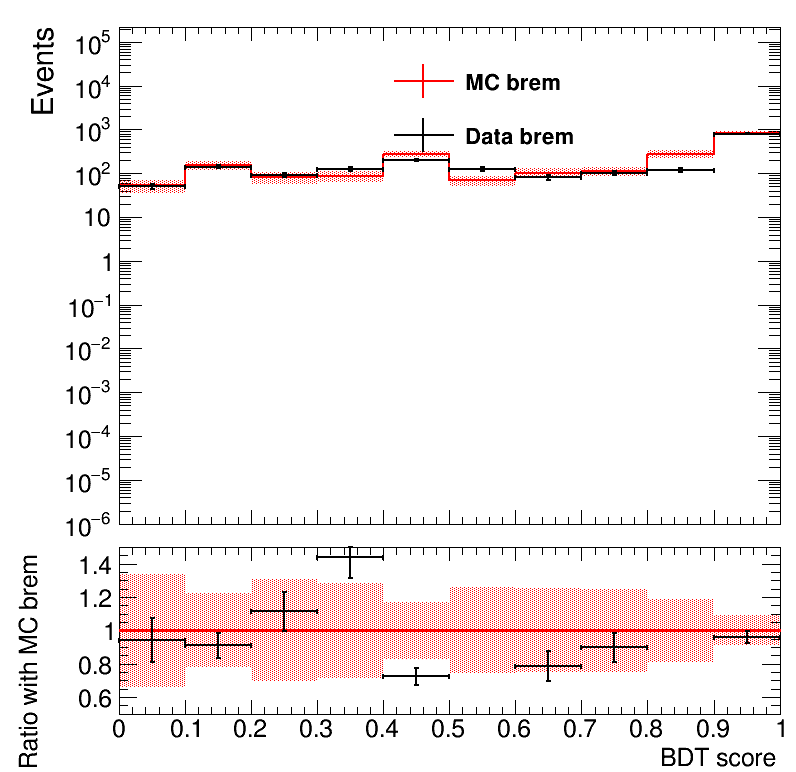

In [29]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot, make_ratio_pEff
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    
c = rt.TCanvas('c','c', 800, 600)
leg = rt.TLegend(0.2,0.80,0.4,0.90)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
hm = {}
hb = {}
pEff = {}
clusterSize_bins = [0, 10, 20, 30, 40, 50, 60, 70]
# if rechit_cut[sig_ver]< 70: clusterSize_bins += [70]
clusterSize_bins += [100, 150, 250, 500]
var = [ZMass, lepPt, lepE, lepEta, cscRechitClusterEta, cscRechitClusterNStation10, cscRechitClusterAvgStation10, cscRechitClusterSize, bdt_score]
title = ['Dimuon mass [GeV]', 'muon pT [GeV]', 'muon E [GeV]', 'muon #eta', 'cluster #eta', 'N_{station}', 'Avg Station', 'N_{rechits}', 'BDT score']
bins = [ [25,int(m1),int(m2)],list(np.arange(0,300,25))+[300, 350, 400,500,800], list(np.arange(0,500,50))+[500,575, 650, 725,800,900,1000]+[1200, 2000], \
        [12,0.8,2.0], [12,0.8,2.0], [5,0,5], [20,0,5],clusterSize_bins, [10,0,1]]
names = ['ZMass','muonPt', 'muonE', 'muonEta', 'cscRechitClusterEta', 'cscRechitClusterNStation10', 'cscRechitClusterAvgStation10', 'cscRechitClusterSize', 'bdtScore']

ratio = [[0.5,1.5], [0.0,1.5], [0.5,1.5], [0.0,1.5], [0,1.5], [0.5, 2], [0.5, 2], [0.5, 1.5], [0.5, 1.5]]
ratio_Nrechits130 = [[0.0,2.0], [0.5,1.5], [0.0,2.0], [0.0,1.5], [0,1.5], [0.5, 2], [0.0, 3], [0.5, 1.5], [0.0, 2.0]]

assert(len(var) == len(title) == len(names) == len(bins)==len(ratio) )

dir_name = '/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/cluster_eff_year'+year+\
'_norm'+str(norm)+'_'+ver+sig_ver
if tag_probe: dir_name+="_tag_probe"
dir_name += '/'
if not os.path.isdir(dir_name):os.makedirs(dir_name)
outputFileName = dir_name +"efficiency_"+'Zmass'+m1+'_'+m2+'_muon'+str(muonPt)+'_norm'+str(norm)+'.root'
print(outputFileName)
outFile = rt.TFile(outputFileName, 'RECREATE')


for j in range(len(bins)):
#     if not j == 3: continue
    if j < 4:
        for i, k in enumerate(cond.keys()):
            total_weight = weight[k]*pileupWeight[k]*mc_corr_weight[k]
            if k[:2] == 'dy': total_weight *= lepOverallSF[k]
            hm[k] = create_TH1D(np.abs(var[j][k][cond[k]]), 'hm1', axis_title = [title[j],'Cluster Efficiency'], binning=bins[j], weights = total_weight[cond[k]])
            hb[k] = create_TH1D(np.abs(var[j][k]), 'hb1', axis_title = [title[j],'Cluster Efficiency'], binning=bins[j],  weights = total_weight)
            hm[k].SetLineColor(std_color_list[i])
            hb[k].SetLineColor(std_color_list[i])
#             print(k, hm[k].Integral()/hb[k].Integral())
            pEff[k] = rt.TEfficiency(hm[k],hb[k])
            pEff[k].SetLineColor(std_color_list[i])
            pEff[k].SetLineWidth(2)
            hm[k].GetYaxis().SetTitle("Events")
            hb[k].GetYaxis().SetTitle("Events")
            if k == 'data': leg.AddEntry(pEff[k], 'Data')
            else: leg.AddEntry(pEff[k], 'MC')
            print(pEff[k].GetEfficiency(10), pEff[k].GetEfficiencyErrorLow(10), pEff[k].GetEfficiencyErrorUp(10))
            outFile.WriteTObject(pEff[k], k+'_'+names[j], "WriteDelete");
        print("no cluster data/mc", hb['data'].Integral()/hb['dy_120_800'].Integral())
        print("with cluster data/mc", hm['data'].Integral()/hm['dy_120_800'].Integral())

        c = make_ratio_pEff([pEff[keys[1]],pEff[keys[0]]], fit = False, logy=False, in_tags = ["MC brem","Data brem"], ratio_bounds = [0.0,1.5], draw_opt = ['E2','E1']) 
        rt.gPad.Update()
        c.Draw()
        c.SaveAs(dir_name+"efficiency_"+names[j]+'_Zmass'+m1+'_'+m2+'_muon'+str(muonPt)+'_norm'+str(norm)+'.png')
        c.SaveAs(dir_name+"efficiency_"+names[j]+'_Zmass'+m1+'_'+m2+'_muon'+str(muonPt)+'_norm'+str(norm)+'.C')
        c = make_ratio_plot([hm[keys[1]],hm[keys[0]]], fit = False, logy=False, in_tags = ["MC brem","Data brem"], ratio_bounds = ratio[j], draw_opt = ['E2','E1']) 
        c.Draw()
        c.SaveAs(dir_name+names[j]+'_Zmass'+m1+'_'+m2+'_muon'+str(muonPt)+'_norm'+str(norm)+'.png')
        c.SaveAs(dir_name+names[j]+'_Zmass'+m1+'_'+m2+'_muon'+str(muonPt)+'_norm'+str(norm)+'.C')
        
        c = make_ratio_plot([hm[keys[1]],hm[keys[0]]], fit = False, logy=True, in_tags = ["MC brem","Data brem"], ratio_bounds = ratio[j], draw_opt = ['E2','E1']) 
        c.Draw()
        c.SaveAs(dir_name+names[j]+'_Zmass'+m1+'_'+m2+'_muon'+str(muonPt)+'_norm'+str(norm)+'_log.png')
        c.SaveAs(dir_name+names[j]+'_Zmass'+m1+'_'+m2+'_muon'+str(muonPt)+'_norm'+str(norm)+'_log.C')
        
        c = make_ratio_plot([hb[keys[1]],hb[keys[0]]], fit = False, logy=False, in_tags = ["MC brem","Data brem"], ratio_bounds = [0.7,1.2], draw_opt = ['E2','E1']) 
        c.Draw()
        c.SaveAs(dir_name+"nocluster_"+names[j]+'_Zmass'+m1+'_'+m2+'_muon'+str(muonPt)+'_norm'+str(norm)+'.png')
        c.SaveAs(dir_name+"nocluster_"+names[j]+'_Zmass'+m1+'_'+m2+'_muon'+str(muonPt)+'_norm'+str(norm)+'.C')
        
        c = make_ratio_plot([hb[keys[1]],hb[keys[0]]], fit = False, logy=True, in_tags = ["MC brem","Data brem"], ratio_bounds = [0.0, 3], draw_opt = ['E2','E1']) 
        c.Draw()
        c.SaveAs(dir_name+"nocluster_"+names[j]+'_Zmass'+m1+'_'+m2+'_muon'+str(muonPt)+'_norm'+str(norm)+'_log.png')
        c.SaveAs(dir_name+"nocluster_"+names[j]+'_Zmass'+m1+'_'+m2+'_muon'+str(muonPt)+'_norm'+str(norm)+'_log.C')
        
        
        #################
        # apply Nrechits >= 130
        #################
#         for i, k in enumerate(cond.keys()):
#             cut = cscRechitClusterSize[k] >= 130
#             total_weight = weight[k]*pileupWeight[k]*mc_corr_weight[k]
#             if k[:2] == 'dy': total_weight *= lepOverallSF[k]
#             hm[k] = create_TH1D(np.abs(var[j][k][cond[k]][cut]), 'hm1', axis_title = [title[j],'Cluster Efficiency'], binning=bins[j], weights = total_weight[cond[k]][cut])
#             hb[k] = create_TH1D(np.abs(var[j][k]), 'hb1', axis_title = [title[j],'Cluster Efficiency'], binning=bins[j],  weights = total_weight)
#             hm[k].SetLineColor(std_color_list[i])
#             hb[k].SetLineColor(std_color_list[i])
#             pEff[k] = rt.TEfficiency(hm[k],hb[k])
#             pEff[k].SetLineColor(std_color_list[i])
#             pEff[k].SetLineWidth(2)
#             hm[k].GetYaxis().SetTitle("Events")
#             hb[k].GetYaxis().SetTitle("Events")
#             if k == 'data': leg.AddEntry(pEff[k], 'Data')
#             else: leg.AddEntry(pEff[k], 'MC')
# #             outFile.WriteTObject(pEff[k], k+'_'+names[j]+'_Nrechits130', "WriteDelete");

#         c = make_ratio_pEff([pEff[keys[1]],pEff[keys[0]]], fit = False, logy=False, in_tags = ["MC brem","Data brem"], ratio_bounds = [0.0,3], draw_opt = ['E2','E1']) 
#         rt.gPad.Update()
#         c.Draw()
#         c.SaveAs(dir_name+"efficiency_"+names[j]+'_Zmass'+m1+'_'+m2+'_muon'+str(muonPt)+'_norm'+str(norm)+'_nRechits130.png')
#         c.SaveAs(dir_name+"efficiency_"+names[j]+'_Zmass'+m1+'_'+m2+'_muon'+str(muonPt)+'_norm'+str(norm)+'_nRechits130.C')
#         c = make_ratio_plot([hm[keys[1]],hm[keys[0]]], fit = False, logy=False, in_tags = ["MC brem","Data brem"], ratio_bounds = ratio_Nrechits130[j], draw_opt = ['E2','E1']) 
#         c.Draw()
#         c.SaveAs(dir_name+names[j]+'_Zmass'+m1+'_'+m2+'_muon'+str(muonPt)+'_norm'+str(norm)+'_nRechits130.png')
#         c.SaveAs(dir_name+names[j]+'_Zmass'+m1+'_'+m2+'_muon'+str(muonPt)+'_norm'+str(norm)+'_nRechits130.C')
        
#         c = make_ratio_plot([hm[keys[1]],hm[keys[0]]], fit = False, logy=True, in_tags = ["MC brem","Data brem"], ratio_bounds = ratio_Nrechits130[j], draw_opt = ['E2','E1']) 
#         c.Draw()
#         c.SaveAs(dir_name+names[j]+'_Zmass'+m1+'_'+m2+'_muon'+str(muonPt)+'_norm'+str(norm)+'_nRechits130_log.png')
#         c.SaveAs(dir_name+names[j]+'_Zmass'+m1+'_'+m2+'_muon'+str(muonPt)+'_norm'+str(norm)+'_nRechits130_log.C')

    else:
        for i, k in enumerate(cond.keys()):
            total_weight = weight[k]*pileupWeight[k]*mc_corr_weight[k]
            if k[:2] == 'dy': total_weight *= lepOverallSF[k]
            hm[k] = create_TH1D(np.abs(var[j][k]), 'hm1', axis_title = [title[j],'Events'], binning=bins[j], weights = total_weight[cond[k]])
            hm[k].SetLineColor(std_color_list[i])
        c = make_ratio_plot([hm[keys[1]],hm[keys[0]]], fit = False, logy=False, in_tags = ["MC brem","Data brem"], ratio_bounds = [0,2], draw_opt = ['E2','E1']) 
        c.Draw()
        c.SaveAs(dir_name+names[j]+'_Zmass'+m1+'_'+m2+'_muon'+str(muonPt)+'_norm'+str(norm)+'.png')
        c.SaveAs(dir_name+names[j]+'_Zmass'+m1+'_'+m2+'_muon'+str(muonPt)+'_norm'+str(norm)+'.C')
        
        c = make_ratio_plot([hm[keys[1]],hm[keys[0]]], fit = False, logy=True, in_tags = ["MC brem","Data brem"], ratio_bounds = ratio[j], draw_opt = ['E2','E1']) 
        c.Draw()
        c.SaveAs(dir_name+names[j]+'_Zmass'+m1+'_'+m2+'_muon'+str(muonPt)+'_norm'+str(norm)+'_log.png')
        c.SaveAs(dir_name+names[j]+'_Zmass'+m1+'_'+m2+'_muon'+str(muonPt)+'_norm'+str(norm)+'_log.C')
#         #################
#         # apply Nrechits >= 130
#         #################
#         for i, k in enumerate(cond.keys()):
#             total_weight = weight[k]*pileupWeight[k]*mc_corr_weight[k]
#             if k[:2] == 'dy': total_weight *= lepOverallSF[k]
#             cut = cscRechitClusterSize[k] >= 130
#             hm[k] = create_TH1D(np.abs(var[j][k][cut]), 'hm1', axis_title = [title[j],'Events'], binning=bins[j], weights = total_weight[cond[k]][cut])
#             hm[k].SetLineColor(std_color_list[i])
#         c = make_ratio_plot([hm[keys[1]],hm[keys[0]]], fit = False, logy=False, in_tags = ["MC brem","Data brem"], ratio_bounds = ratio_Nrechits130[j], draw_opt = ['E2','E1']) 
#         c.Draw()
#         c.SaveAs(dir_name+names[j]+'_Zmass'+m1+'_'+m2+'_muon'+str(muonPt)+'_norm'+str(norm)+'_nRechits130.png')
#         c.SaveAs(dir_name+names[j]+'_Zmass'+m1+'_'+m2+'_muon'+str(muonPt)+'_norm'+str(norm)+'_nRechits130.C')
        
#         c = make_ratio_plot([hm[keys[1]],hm[keys[0]]], fit = False, logy=True, in_tags = ["MC brem","Data brem"], ratio_bounds = ratio_Nrechits130[j], draw_opt = ['E2','E1']) 
#         c.Draw()
#         c.SaveAs(dir_name+names[j]+'_Zmass'+m1+'_'+m2+'_muon'+str(muonPt)+'_norm'+str(norm)+'_nRechits130_log.png')
#         c.SaveAs(dir_name+names[j]+'_Zmass'+m1+'_'+m2+'_muon'+str(muonPt)+'_norm'+str(norm)+'_nRechits130_log.C')
outFile.Close()




